In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask_ml.model_selection as dcv


import cudf

import cupy

from cuml import svm

from scipy.io import arff

from sklearn.neural_network import MLPClassifier
from cuml.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler 

#from cuml.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from cuml.neighbors import KNeighborsClassifier

from sklearn.preprocessing import RobustScaler, Normalizer, QuantileTransformer, PowerTransformer, OneHotEncoder

#from cuml.experimental.preprocessing import RobustScaler

from cuml.ensemble import RandomForestClassifier

# EEG Data

In [2]:
data = arff.loadarff('data/eeg/EEG Eye State.arff')

In [3]:
df = pd.DataFrame(data[0])

df.eyeDetection = df.eyeDetection.astype('int32')

df = df.rename(columns = {'eyeDetection' : 'y'})

X = df.iloc[:, :-1]
y = df.y

df

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,y
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,1
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,1
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,1
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,1


In [4]:
scaler = RobustScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 5000, random_state = 42)

In [5]:
y_train = y_train.to_numpy().astype('int')

In [6]:
X_train.dtype, y_train.dtype

(dtype('float64'), dtype('int64'))

## SVM

In [7]:
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1/(X.shape[1])]

classifier = svm.SVC(kernel='rbf')
#search_results = GridSearchCV(classifier, {'C' : C_list, 'gamma' : gamma_list}, n_jobs = -1)

In [8]:
#search_results.fit(X_train, y_train)

classifier.fit(X_train, y_train)

RuntimeError: exception occured! file=../src/svm/svc_impl.cuh line=65: Only binary classification is implemented at the moment
Obtained 64 stack frames
#0 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN4raft9exception18collect_call_stackEv+0x46) [0x7f47054fe016]
#1 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN2ML3SVM6svcFitIdEEvRKN4raft8handle_tEPT_iiS7_RKNS0_12svmParameterERN8MLCommon6Matrix12KernelParamsERNS0_8svmModelIS6_EEPKS6_+0xe58) [0x7f47058c42a8]
#2 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/svm/svc.cpython-38-x86_64-linux-gnu.so(+0x42bd3) [0x7f46dac43bd3]
#3 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/svm/svc.cpython-38-x86_64-linux-gnu.so(+0x45509) [0x7f46dac46509]
#4 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x255) [0x55b99ce4b2b5]
#5 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55b99cef7de1]
#6 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#7 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55b99ced8007]
#8 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x4ca3) [0x55b99cefa8c3]
#9 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#10 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyEval_EvalCodeEx+0x39) [0x55b99ced7559]
#11 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyEval_EvalCode+0x1b) [0x55b99cf7a9ab]
#12 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x2731de) [0x55b99cf991de]
#13 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55b99ce4ed4b]
#14 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55b99cef654f]
#15 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55b99cea8ea3]
#16 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x55b99cef7957]
#17 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55b99cea8ea3]
#18 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x55b99cef7957]
#19 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55b99cea8ea3]
#20 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1958c9) [0x55b99cebb8c9]
#21 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55b99cef666b]
#22 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x1a6) [0x55b99ced7706]
#23 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55b99cef654f]
#24 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x1a6) [0x55b99ced7706]
#25 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55b99cef666b]
#26 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#27 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55b99ced78d8]
#28 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b1f91) [0x55b99ced7f91]
#29 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55b99ce4b0be]
#30 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55b99cef7de1]
#31 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#32 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55b99ced8007]
#33 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1782) [0x55b99cef73a2]
#34 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55b99ceb85da]
#35 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55b99ce4ed4b]
#36 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55b99ce613ea]
#37 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55b99cf43a4f]
#38 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55b99ce4efc2]
#39 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55b99cef654f]
#40 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#41 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55b99ced78d8]
#42 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55b99cef666b]
#43 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55b99ceb85da]
#44 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55b99ce4ed4b]
#45 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55b99ce613ea]
#46 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55b99cf43a4f]
#47 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55b99ce4efc2]
#48 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55b99cef654f]
#49 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#50 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55b99ced8007]
#51 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55b99cef654f]
#52 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55b99ceb85da]
#53 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55b99ce4ed4b]
#54 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55b99ce613ea]
#55 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55b99cf43a4f]
#56 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55b99ce4efc2]
#57 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55b99cef654f]
#58 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55b99ced6503]
#59 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55b99ced78d8]
#60 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b1f91) [0x55b99ced7f91]
#61 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55b99ce4b0be]
#62 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55b99cef7de1]
#63 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55b99cea8ea3]


In [65]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,C,gamma,score
59,100.000,0.071429,0.0696
65,1000.000,0.071429,0.0734
53,10.000,0.071429,0.0874
64,1000.000,0.010000,0.1004
58,100.000,0.010000,0.1378
...,...,...,...
27,0.001,0.001000,0.4376
28,0.001,0.010000,0.4376
29,0.001,0.071429,0.4376
31,0.010,0.000010,0.4376


In [66]:
opt_classifier = search_results.best_estimator_
opt_C = search_results.best_params_['C']
opt_gamma = search_results.best_params_['gamma']

# just a copy/paste of test set evaluation from before
opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},gamma={opt_gamma}): {opt_test_score:.3f}') 

Test set error for optimum classifier(C=100.0,gamma=0.07142857142857142): 0.056


## Logistic Regression

In [30]:
classifier_none = LogisticRegression(penalty = 'none', max_iter = 10000)
search_results = GridSearchCV(classifier_none, param_grid = {})

In [31]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(penalty='l1', tol=0.0001, C=1.0, fit_intercept=True, max_iter=10000, linesearch_max_iter=50, verbose=4, l1_ratio=None, solver='qn', handle=<cuml.raft.common.handle.Handle object at 0x7ff2a161e770>, output_type='input'),
             param_grid={})

In [32]:
error = 1 - search_results.cv_results_['mean_test_score']
print('Training error no penalty:', score)

no_penalty_df = pd.DataFrame().assign(C = [None], penalty = [None], error = error)

Training error no penalty: [0.34880002]


In [35]:
C_vals = range(-8, 5)
C_vals = [10 ** val for val in C_vals]
penalty = ['l1', 'l2']

metrics = ['accuracy', 'f1', 'roc_auc']


params = {'penalty' : penalty, 'C' : C_vals}

classifier = LogisticRegression(output_type = 'numpy')
search_results = dcv.GridSearchCV(classifier, params)

In [36]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, max_iter=1000, linesearch_max_iter=50, verbose=4, l1_ratio=None, solver='qn', handle=<cuml.raft.common.handle.Handle object at 0x7ff2a10d5d30>, output_type='numpy'),
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2']})

In [40]:
results = pd.DataFrame(search_results.cv_results_['params'])

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['error'] = 1 - search_results.cv_results_['mean_test_score']

results = results.append(no_penalty_df)

results.sort_values(by = 'error')

,C,penalty,error
17,1.000000e+00,l2,0.3482
0,1.000000e-08,l1,0.3484
24,1.000000e+04,l1,0.3484
2,1.000000e-07,l1,0.3484
4,1.000000e-06,l1,0.3484
6,1.000000e-05,l1,0.3484
21,1.000000e+02,l2,0.3484
19,1.000000e+01,l2,0.3484
25,1.000000e+04,l2,0.3484
23,1.000000e+03,l2,0.3486


In [41]:
opt_classifier = search_results.best_estimator_

opt_penalty = search_results.best_params_['penalty']
opt_C = search_results.best_params_['C']

opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},penalty={opt_penalty}): {opt_test_score:.3f}')

Test set error for optimum classifier(C=1,penalty=l2): 0.360


## MLP

In [79]:
hidden_units = [1, 2, 4, 8, 32, 64, 128, 256]
momentum = [0, 0.2, 0.5, 0.9]
classifier = MLPClassifier(solver = 'sgd', max_iter = 5000)
search_results = GridSearchCV(classifier, {'hidden_layer_sizes': hidden_units, 'momentum': momentum}, n_jobs = -1)

In [75]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(max_iter=5000, solver='sgd'),
             param_grid={'hidden_layer_sizes': [1, 2, 4, 8, 32, 128],
                         'momentum': [0, 0.2, 0.5, 0.9]})

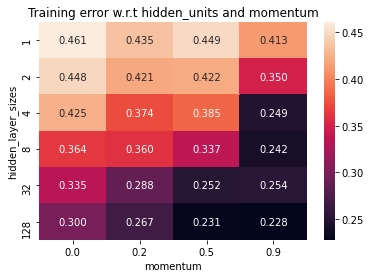

In [76]:
results = pd.DataFrame( search_results.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score'] = 1 - search_results.cv_results_['mean_test_score']

# turn a long table into a 2-D table with C being the 1st axis (y-axis) and gamma as the 2nd (x-axis)
results = results.pivot('hidden_layer_sizes','momentum','score')

# and plot it
# using the dataframe means we don't need the wrapper fct around sns.heatmap we used before
sns.heatmap(results,annot=True, fmt='.3f') 
plt.title('Training error w.r.t hidden_units and momentum')
plt.show()

In [78]:
opt_classifier = search_results.best_estimator_

opt_hid = search_results.best_params_['hidden_layer_sizes']
opt_mom = search_results.best_params_['momentum']

opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error


print(f'Test set error for optimum classifier(hidden_layer_sizes = {opt_hid}, momentum = {opt_mom}): {opt_test_score:.3f}')

Test set error for optimum classifier(hidden_layer_sizes = 128, momentum = 0.9): 0.259


## Random Forest Decision Tree

In [7]:
X_cudf_train = cudf.DataFrame(X_train)
y_cudf_train = cudf.Series(y_train)

In [8]:
n_estimators = [1, 1e1, 1e2, 1e3, 1e4]
n_estimators = [int(item) for item in n_estimators]

classifier = RandomForestClassifier()
search_results = dcv.GridSearchCV(classifier, {'n_estimators': n_estimators})

In [10]:
classifier.fit(X_train, y_train, True)

RuntimeError: CUDA error encountered at: file=/opt/conda/envs/rapids/conda-bld/libcuml_1614210250760/work/cpp/src/decisiontree/quantile/quantile.cuh line=150: call='cub::DeviceRadixSort::SortKeys( (void *)d_temp_storage->data(), temp_storage_bytes, &d_keys_in[batch_offset], d_keys_out->data(), n_sampled_rows, 0, 8 * sizeof(T), tempmem->stream)', Reason=cudaErrorInvalidValue:invalid argument
Obtained 64 stack frames
#0 in /home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN4raft9exception18collect_call_stackEv+0x46) [0x7f73161e0f36]
#1 in /home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN4raft10cuda_errorC1ERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x69) [0x7f73161e1699]
#2 in /home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN2ML12DecisionTree19preprocess_quantileIdiEEvPKT_PKjiiiiSt10shared_ptrI15TemporaryMemoryIS2_T0_EE+0xaaf) [0x7f73162fa51f]
#3 in /home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN2ML12rfClassifierIdE3fitERKN4raft8handle_tEPKdiiPiiRPNS_20RandomForestMetaDataIdiEE+0xde3) [0x7f7316529bd3]
#4 in /home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN2ML3fitERKN4raft8handle_tERPNS_20RandomForestMetaDataIdiEEPdiiPiiNS_9RF_paramsEi+0x1fd) [0x7f73165218dd]
#5 in /home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/ensemble/randomforestclassifier.cpython-38-x86_64-linux-gnu.so(+0x3d95b) [0x7f72ec50d95b]
#6 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(PyObject_Call+0x255) [0x56524a6312b5]
#7 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x56524a6ddde1]
#8 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#9 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1b2007) [0x56524a6be007]
#10 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x4ca3) [0x56524a6e08c3]
#11 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#12 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(PyEval_EvalCodeEx+0x39) [0x56524a6bd559]
#13 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(PyEval_EvalCode+0x1b) [0x56524a7609ab]
#14 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x2731de) [0x56524a77f1de]
#15 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128d4b) [0x56524a634d4b]
#16 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x56524a6dc54f]
#17 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x182ea3) [0x56524a68eea3]
#18 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x56524a6dd957]
#19 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x182ea3) [0x56524a68eea3]
#20 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x56524a6dd957]
#21 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x182ea3) [0x56524a68eea3]
#22 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1958c9) [0x56524a6a18c9]
#23 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x56524a6dc66b]
#24 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyFunction_Vectorcall+0x1a6) [0x56524a6bd706]
#25 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x56524a6dc54f]
#26 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyFunction_Vectorcall+0x1a6) [0x56524a6bd706]
#27 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x56524a6dc66b]
#28 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#29 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyFunction_Vectorcall+0x378) [0x56524a6bd8d8]
#30 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1b1f91) [0x56524a6bdf91]
#31 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(PyObject_Call+0x5e) [0x56524a6310be]
#32 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x56524a6ddde1]
#33 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#34 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1b2007) [0x56524a6be007]
#35 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x1782) [0x56524a6dd3a2]
#36 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1925da) [0x56524a69e5da]
#37 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128d4b) [0x56524a634d4b]
#38 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x13b3ea) [0x56524a6473ea]
#39 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x21da4f) [0x56524a729a4f]
#40 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128fc2) [0x56524a634fc2]
#41 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x56524a6dc54f]
#42 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#43 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyFunction_Vectorcall+0x378) [0x56524a6bd8d8]
#44 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x56524a6dc66b]
#45 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1925da) [0x56524a69e5da]
#46 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128d4b) [0x56524a634d4b]
#47 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x13b3ea) [0x56524a6473ea]
#48 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x21da4f) [0x56524a729a4f]
#49 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128fc2) [0x56524a634fc2]
#50 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x56524a6dc54f]
#51 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#52 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1b2007) [0x56524a6be007]
#53 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x56524a6dc54f]
#54 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1925da) [0x56524a69e5da]
#55 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128d4b) [0x56524a634d4b]
#56 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x13b3ea) [0x56524a6473ea]
#57 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x21da4f) [0x56524a729a4f]
#58 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x128fc2) [0x56524a634fc2]
#59 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x56524a6dc54f]
#60 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x56524a6bc503]
#61 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(_PyFunction_Vectorcall+0x378) [0x56524a6bd8d8]
#62 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(+0x1b1f91) [0x56524a6bdf91]
#63 in /home/jitarth/anaconda3/envs/rapids-0.18/bin/python(PyObject_Call+0x5e) [0x56524a6310be]


In [94]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,n_estimators,score
4,10000,0.1094
3,1000,0.1108
2,100,0.1154
1,10,0.1574
0,1,0.2728


In [60]:
opt_classifier = search_results.best_estimator_ 

opt_est = search_results.best_params_['n_estimators']

opt_classifier.fit(X_train, y_train)

opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(n_estimators = {opt_est}): {opt_test_score:.3f}')

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

## K Nearest Neighbors

In [15]:
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

classifier = KNeighborsClassifier()
search_results = dcv.GridSearchCV(classifier, {'n_neighbors': n_neighbors})

Exception ignored in: <bound method NearestNeighbors.__del__ of KNeighborsClassifier()>
Traceback (most recent call last):
  File "cuml/neighbors/nearest_neighbors.pyx", line 849, in cuml.neighbors.nearest_neighbors.NearestNeighbors.__del__
  File "cuml/common/base.pyx", line 267, in cuml.common.base.Base.__getattr__
AttributeError: 


RuntimeError: CUDA error encountered at: file=/opt/conda/envs/rapids/conda-bld/cuml_1614355287413/work/python/_external_repositories/raft/cpp/include/raft/handle.hpp line=219: call='cudaEventCreateWithFlags(&event_, 0x02)', Reason=cudaErrorIllegalAddress:an illegal memory access was encountered
Obtained 64 stack frames
#0 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/raft/common/handle.cpython-38-x86_64-linux-gnu.so(_ZN4raft9exception18collect_call_stackEv+0x46) [0x7fe403cfa0f6]
#1 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/raft/common/handle.cpython-38-x86_64-linux-gnu.so(_ZN4raft10cuda_errorC1ERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x69) [0x7fe403cfa819]
#2 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/raft/common/handle.cpython-38-x86_64-linux-gnu.so(_ZN4raft8handle_t16create_resourcesEv+0x40a) [0x7fe403cfb11a]
#3 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/raft/common/handle.cpython-38-x86_64-linux-gnu.so(_ZN4raft8handle_tC1Ei+0x16c) [0x7fe403cff1dc]
#4 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/raft/common/handle.cpython-38-x86_64-linux-gnu.so(+0x2c0d4) [0x7fe403cf50d4]
#5 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x124ef6) [0x55d7cddb7ef6]
#6 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/base.cpython-38-x86_64-linux-gnu.so(+0xc44c) [0x7fe403d6644c]
#7 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/base.cpython-38-x86_64-linux-gnu.so(+0x108bd) [0x7fe403d6a8bd]
#8 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_MakeTpCall+0x31e) [0x55d7cddcdf2e]
#9 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_FastCallDict+0x487) [0x55d7cddb2fb7]
#10 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_Call_Prepend+0x63) [0x55d7cddbd983]
#11 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/neighbors/nearest_neighbors.cpython-38-x86_64-linux-gnu.so(+0x2a30c) [0x7fe402c4c30c]
#12 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/neighbors/nearest_neighbors.cpython-38-x86_64-linux-gnu.so(+0x2d73b) [0x7fe402c4f73b]
#13 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_MakeTpCall+0x31e) [0x55d7cddcdf2e]
#14 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_FastCallDict+0x487) [0x55d7cddb2fb7]
#15 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_Call_Prepend+0x63) [0x55d7cddbd983]
#16 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/neighbors/kneighbors_classifier.cpython-38-x86_64-linux-gnu.so(+0x288dc) [0x7fe402b868dc]
#17 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/neighbors/kneighbors_classifier.cpython-38-x86_64-linux-gnu.so(+0x2ae3e) [0x7fe402b88e3e]
#18 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_MakeTpCall+0x31e) [0x55d7cddcdf2e]
#19 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b26f8) [0x55d7cde456f8]
#20 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55d7cddb80be]
#21 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b3ac0) [0x55d7cde46ac0]
#22 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyObject_MakeTpCall+0x2eb) [0x55d7cddcdefb]
#23 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x4f2e) [0x55d7cde67b4e]
#24 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#25 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyEval_EvalCodeEx+0x39) [0x55d7cde44559]
#26 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyEval_EvalCode+0x1b) [0x55d7cdee79ab]
#27 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x2731de) [0x55d7cdf061de]
#28 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]
#29 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#30 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55d7cde15ea3]
#31 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x55d7cde64957]
#32 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55d7cde15ea3]
#33 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x55d7cde64957]
#34 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55d7cde15ea3]
#35 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1958c9) [0x55d7cde288c9]
#36 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55d7cde6366b]
#37 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x1a6) [0x55d7cde44706]
#38 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#39 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x1a6) [0x55d7cde44706]
#40 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55d7cde6366b]
#41 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#42 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55d7cde448d8]
#43 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b1f91) [0x55d7cde44f91]
#44 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55d7cddb80be]
#45 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55d7cde64de1]
#46 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#47 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55d7cde45007]
#48 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1782) [0x55d7cde643a2]
#49 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55d7cde255da]
#50 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]
#51 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55d7cddce3ea]
#52 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55d7cdeb0a4f]
#53 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55d7cddbbfc2]
#54 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#55 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#56 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55d7cde448d8]
#57 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55d7cde6366b]
#58 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55d7cde255da]
#59 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]
#60 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55d7cddce3ea]
#61 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55d7cdeb0a4f]
#62 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55d7cddbbfc2]
#63 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]


In [8]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(weights='uniform'),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [9]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,n_neighbors,score
0,1,0.0750
2,3,0.0790
4,5,0.0870
3,4,0.0902
1,2,0.0934
6,7,0.0954
5,6,0.0970
8,9,0.1000
7,8,0.1036
9,10,0.1054


In [14]:
opt_classifier = search_results.best_estimator_ 

opt_nei = search_results.best_params_['n_neighbors']

opt_classifier.fit(X_train, y_train)

opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(n_neighbors = {opt_nei}): {opt_test_score:.3f}')

RuntimeError: CUDA error encountered at: file=../src_prims/selection/knn.cuh line=697: call='cudaPeekAtLastError()', Reason=cudaErrorIllegalAddress:an illegal memory access was encountered
Obtained 64 stack frames
#0 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN4raft9exception18collect_call_stackEv+0x46) [0x7fe42d312016]
#1 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN4raft10cuda_errorC1ERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x69) [0x7fe42d312779]
#2 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(+0x4655de) [0x7fe42d5975de]
#3 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/common/../../../../libcuml++.so(_ZN2ML12knn_classifyERN4raft8handle_tEPiPlRSt6vectorIS3_SaIS3_EEmmi+0x2ea) [0x7fe42d595d3a]
#4 in /home/jitarth/anaconda3/envs/rapids-0.19/lib/python3.8/site-packages/cuml/neighbors/kneighbors_classifier.cpython-38-x86_64-linux-gnu.so(+0x2e836) [0x7fe402b8c836]
#5 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x255) [0x55d7cddb82b5]
#6 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55d7cde64de1]
#7 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#8 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55d7cde448d8]
#9 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b1f91) [0x55d7cde44f91]
#10 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55d7cddb80be]
#11 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55d7cde64de1]
#12 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#13 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55d7cde448d8]
#14 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55d7cddb80be]
#15 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55d7cde64de1]
#16 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#17 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55d7cde45007]
#18 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x4ca3) [0x55d7cde678c3]
#19 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#20 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyEval_EvalCodeEx+0x39) [0x55d7cde44559]
#21 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyEval_EvalCode+0x1b) [0x55d7cdee79ab]
#22 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x2731de) [0x55d7cdf061de]
#23 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]
#24 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#25 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55d7cde15ea3]
#26 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x55d7cde64957]
#27 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55d7cde15ea3]
#28 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1d37) [0x55d7cde64957]
#29 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x182ea3) [0x55d7cde15ea3]
#30 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1958c9) [0x55d7cde288c9]
#31 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55d7cde6366b]
#32 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x1a6) [0x55d7cde44706]
#33 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#34 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x1a6) [0x55d7cde44706]
#35 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55d7cde6366b]
#36 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#37 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55d7cde448d8]
#38 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b1f91) [0x55d7cde44f91]
#39 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(PyObject_Call+0x5e) [0x55d7cddb80be]
#40 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x21c1) [0x55d7cde64de1]
#41 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#42 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55d7cde45007]
#43 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x1782) [0x55d7cde643a2]
#44 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55d7cde255da]
#45 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]
#46 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55d7cddce3ea]
#47 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55d7cdeb0a4f]
#48 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55d7cddbbfc2]
#49 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#50 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#51 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyFunction_Vectorcall+0x378) [0x55d7cde448d8]
#52 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0xa4b) [0x55d7cde6366b]
#53 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55d7cde255da]
#54 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]
#55 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x13b3ea) [0x55d7cddce3ea]
#56 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x21da4f) [0x55d7cdeb0a4f]
#57 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128fc2) [0x55d7cddbbfc2]
#58 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#59 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalCodeWithName+0x2c3) [0x55d7cde43503]
#60 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1b2007) [0x55d7cde45007]
#61 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(_PyEval_EvalFrameDefault+0x92f) [0x55d7cde6354f]
#62 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x1925da) [0x55d7cde255da]
#63 in /home/jitarth/anaconda3/envs/rapids-0.19/bin/python(+0x128d4b) [0x55d7cddbbd4b]


# League Data

In [77]:
df = pd.read_csv('data/league/high_diamond_ranked_10min.csv')
df = df.drop(columns = 'gameId')
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,1,54,0,0,6,4,8,1,1,0,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,0,23,1,0,6,7,5,0,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,0,14,4,1,2,3,3,1,1,0,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


In [78]:
scaler = RobustScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 5000, random_state = 42)

In [79]:
y_train = y_train.to_numpy()

## SVM

In [80]:
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1/(X.shape[1])]

classifier = svm.SVC()
search_results = GridSearchCV(classifier, {'C' : C_list, 'gamma' : gamma_list})

In [82]:
search_results.fit(X, y)

/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 410, in inner_with_setters
    return func(*args, **kwargs)
  File "cuml/svm/svc.pyx", line 400, in cuml.svm.svc.SVC.fit
  File "cuml/svm/svc.pyx", line 348, in cuml.svm.svc.SVC._get_num_classes
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cupy/manipulation/add_remove.py", line 112, in unique
    ar.sort()
  File "cupy/core/core.pyx", line 708, in cupy.core.core.ndarray.sort

/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 410, in inner_with_setters
    return func(*args, **kwargs)
  File "cuml/svm/svc.pyx", line 400, in cuml.svm.svc.SVC.fit
  File "cuml/svm/svc.pyx", line 348, in cuml.svm.svc.SVC._get_num_classes
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cupy/manipulation/add_remove.py", line 112, in unique
    ar.sort()
  File "cupy/core/core.pyx", line 708, in cupy.core.core.ndarray.sort

/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 410, in inner_with_setters
    return func(*args, **kwargs)
  File "cuml/svm/svc.pyx", line 400, in cuml.svm.svc.SVC.fit
  File "cuml/svm/svc.pyx", line 348, in cuml.svm.svc.SVC._get_num_classes
  File "/home/jitarth/anaconda3/envs/rapids-0.18/lib/python3.8/site-packages/cupy/manipulation/add_remove.py", line 112, in unique
    ar.sort()
  File "cupy/core/core.pyx", line 708, in cupy.core.core.ndarray.sort

RuntimeError: radix_sort: failed on 2nd step: cudaErrorInvalidValue: invalid argument

In [37]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,C,gamma,score
8,1.000000e-06,0.000100,0.222
33,1.000000e-02,0.001000,0.222
0,1.000000e-07,0.000001,NaN
1,1.000000e-07,0.000010,NaN
2,1.000000e-07,0.000100,NaN
...,...,...,...
61,1.000000e+03,0.000010,NaN
62,1.000000e+03,0.000100,NaN
63,1.000000e+03,0.001000,NaN
64,1.000000e+03,0.010000,NaN


In [95]:
opt_classifier = search_results.best_estimator_
opt_C = search_results.best_params_['C']
opt_gamma = search_results.best_params_['gamma']

# just a copy/paste of test set evaluation from before
opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},gamma={opt_gamma}): {opt_test_score:.3f}') 

Test set error for optimum classifier(C=10.0,gamma=1e-05): 0.272


## Logistic Regression

In [97]:
classifier_none = LogisticRegression(penalty = 'none', solver = 'saga', max_iter = 10000, n_jobs = -1)
search_results = GridSearchCV(classifier_none, param_grid = {}, n_jobs = -1)

In [98]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                          penalty='none', solver='saga'),
             param_grid={})

In [99]:
score = 1 - search_results.cv_results_['mean_test_score']
print('Training error no penalty:', score)

no_penalty_df = pd.DataFrame().assign(C = ['none'], penalty = ['none'], score = score)

Training error no penalty: [0.268]


In [100]:
C_vals = range(-8, 5)
C_vals = [10 ** val for val in C_vals]
penalty = ['l1', 'l2']

classifier = LogisticRegression(solver = 'saga', max_iter = 10000, n_jobs = -1)
search_results = GridSearchCV(classifier, {'penalty' : penalty, 'C' : C_vals}, n_jobs = -1)

In [101]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2']})

In [102]:
results = pd.DataFrame(search_results.cv_results_['params'])

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score'] = 1 - search_results.cv_results_['mean_test_score']

results = results.append(no_penalty_df)

results.sort_values(by = 'score')

,C,penalty,score
14,0.1,l1,0.2654
13,0.01,l2,0.2666
9,0.0001,l2,0.2668
16,1,l1,0.2676
17,1,l2,0.2678
11,0.001,l2,0.2678
24,10000,l1,0.2680
23,1000,l2,0.2680
22,1000,l1,0.2680
21,100,l2,0.2680


In [103]:
opt_classifier = search_results.best_estimator_ 

opt_penalty = search_results.best_params_['penalty']
opt_C = search_results.best_params_['C']

opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},penalty={opt_penalty}): {opt_test_score:.3f}')

Test set error for optimum classifier(C=0.1,penalty=l1): 0.272


## MLP

In [104]:
hidden_units = [1, 2, 4, 8, 32, 64, 128, 256]
momentum = [0, 0.2, 0.5, 0.9]
classifier = MLPClassifier(solver = 'sgd', max_iter = 5000)
search_results = GridSearchCV(classifier, {'hidden_layer_sizes': hidden_units, 'momentum': momentum}, n_jobs = -1)

In [105]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(max_iter=5000, solver='sgd'),
             param_grid={'hidden_layer_sizes': [1, 2, 4, 8, 32, 64, 128, 256],
                         'momentum': [0, 0.2, 0.5, 0.9]})

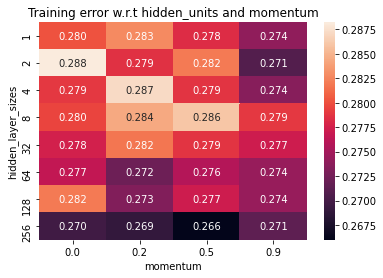

In [106]:
results = pd.DataFrame( search_results.cv_results_['params'] )

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results = results.pivot('hidden_layer_sizes','momentum','score')

sns.heatmap(results,annot=True, fmt='.3f') 
plt.title('Training error w.r.t hidden_units and momentum')
plt.show()

In [108]:
opt_classifier = search_results.best_estimator_

opt_hid = search_results.best_params_['hidden_layer_sizes']
opt_mom = search_results.best_params_['momentum']

opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error


print(f'Test set error for optimum classifier(hidden_layer_sizes = {opt_hid}, momentum = {opt_mom}): {opt_test_score:.3f}')

Test set error for optimum classifier(hidden_layer_sizes = 256, momentum = 0.5): 0.276


## Random Forest Decision Tree

In [53]:
n_estimators = [1, 1e1, 1e2, 1e3, 1e4]
n_estimators = [int(item) for item in n_estimators]

classifier = RandomForestClassifier()
search_results = dcv.GridSearchCV(classifier, {'n_estimators': n_estimators})

In [54]:
search_results.fit(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'fit'

In [87]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,n_estimators,score
4,10000,0.2762
3,1000,0.2780
2,100,0.2794
1,10,0.3002
0,1,0.3646


In [88]:
opt_classifier = search_results.best_estimator_ 

opt_est = search_results.best_params_['n_estimators']

opt_classifier.fit(X_train, y_train)

opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(n_estimators = {opt_est}): {opt_test_score:.3f}')

Test set error for optimum classifier(n_estimators = 10000): 0.274


# CSGO Data

In [59]:
df = pd.read_csv('data/csgo/csgo_round_snapshots.csv')

In [60]:
def conv_winner(winner):
    if winner == 'T':
        return 0
    elif winner == 'CT':
        return 1
    

df.round_winner = df.round_winner.apply(conv_winner)
df.bomb_planted = df.bomb_planted.astype('int32')

df = pd.concat((df, pd.get_dummies(df.map)), 1)
df = df.drop(columns = ['map'])

In [61]:
y = df.round_winner
X = df.drop(columns = ['round_winner'])

df

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,...,t_grenade_decoygrenade,round_winner,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,...,0.0,1,0,1,0,0,0,0,0,0
1,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,...,0.0,1,0,1,0,0,0,0,0,0
2,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,1,0,1,0,0,0,0,0,0
3,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,...,0.0,1,0,1,0,0,0,0,0,0
4,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,...,0.0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,1,200.0,242.0,195.0,359.0,100.0,5950.0,...,0.0,0,0,0,0,0,0,0,1,0
122406,174.93,11.0,15.0,0,500.0,500.0,95.0,175.0,11500.0,23900.0,...,0.0,0,0,0,0,0,0,0,1,0
122407,114.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,0.0,0,0,0,0,0,0,0,1,0
122408,94.93,11.0,15.0,0,500.0,500.0,495.0,475.0,1200.0,6700.0,...,0.0,0,0,0,0,0,0,0,1,0


In [62]:
scaler = RobustScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 5000, random_state = 42)

## SVM

In [49]:
C_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1/(X.shape[1])]

classifier = svm.SVC(kernel='rbf')
search_results = GridSearchCV(classifier, {'C' : C_list, 'gamma' : gamma_list}, n_jobs = -1)

In [142]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                               1.0, 10.0, 100.0, 1000.0],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                   0.010416666666666666]})

In [143]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,C,gamma,score
53,10.000,0.010417,0.2414
57,100.000,0.001000,0.2416
52,10.000,0.010000,0.2418
63,1000.000,0.001000,0.2428
56,100.000,0.000100,0.2436
...,...,...,...
27,0.001,0.001000,0.4824
28,0.001,0.010000,0.4824
29,0.001,0.010417,0.4824
31,0.010,0.000010,0.4824


In [144]:
opt_classifier = search_results.best_estimator_
opt_C = search_results.best_params_['C']
opt_gamma = search_results.best_params_['gamma']

# just a copy/paste of test set evaluation from before
opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},gamma={opt_gamma}): {opt_test_score:.3f}') 

Test set error for optimum classifier(C=10.0,gamma=0.010416666666666666): 0.254


## Logistic Regression

In [50]:
classifier_none = LogisticRegression(penalty = 'none', solver = 'saga', max_iter = 10000, n_jobs = -1)
search_results = GridSearchCV(classifier_none, param_grid = {})

In [51]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                          penalty='none', solver='saga'),
             param_grid={})

In [52]:
score = 1 - search_results.cv_results_['mean_test_score']
print('Training error no penalty:', score)

no_penalty_df = pd.DataFrame().assign(C = ['none'], penalty = ['none'], score = score)

Training error no penalty: [0.243]


In [53]:
C_vals = range(-8, 5)
C_vals = [10 ** val for val in C_vals]
penalty = ['l1', 'l2']

classifier = LogisticRegression(solver = 'saga', max_iter = 10000, n_jobs = -1)
search_results = GridSearchCV(classifier, {'penalty' : penalty, 'C' : C_vals}, n_jobs = -1)

In [54]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2']})

In [55]:
results = pd.DataFrame(search_results.cv_results_['params'])

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score'] = 1 - search_results.cv_results_['mean_test_score']

results = results.append(no_penalty_df)

results.sort_values(by = 'score')

,C,penalty,score
15,0.1,l2,0.2406
16,1,l1,0.2412
17,1,l2,0.2416
22,1000,l1,0.2428
20,100,l1,0.2428
19,10,l2,0.2428
0,none,none,0.2430
24,10000,l1,0.2430
23,1000,l2,0.2430
21,100,l2,0.2430


In [56]:
opt_classifier = search_results.best_estimator_ 

opt_penalty = search_results.best_params_['penalty']
opt_C = search_results.best_params_['C']

opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},penalty={opt_penalty}): {opt_test_score:.3f}')

Test set error for optimum classifier(C=0.1,penalty=l2): 0.253


## MLP

In [12]:
hidden_units = [1, 2, 4, 8, 32, 64, 128, 256]
momentum = [0, 0.2, 0.5, 0.9]
classifier = MLPClassifier(solver = 'adam', max_iter = 5000)
search_results = GridSearchCV(classifier, {'hidden_layer_sizes': hidden_units})

In [13]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(max_iter=5000),
             param_grid={'hidden_layer_sizes': [1, 2, 4, 8, 32, 64, 128, 256]})

In [14]:
results = pd.DataFrame( search_results.cv_results_['params'] )

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results = results.pivot('hidden_layer_sizes','momentum','score')

sns.heatmap(results,annot=True, fmt='.3f') 
plt.title('Training error w.r.t hidden_units and momentum')
plt.show()

KeyError: 'momentum'

In [15]:
results = pd.DataFrame( search_results.cv_results_['params'] )

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,hidden_layer_sizes,score
0,1,0.2478
1,2,0.2498
2,4,0.2520
3,8,0.2568
7,256,0.2628
6,128,0.2670
4,32,0.2748
5,64,0.2764


In [17]:
opt_classifier = search_results.best_estimator_

opt_hid = search_results.best_params_['hidden_layer_sizes']

opt_classifier.fit(X_train, y_train)
opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error


print(f'Test set error for optimum classifier(hidden_layer_sizes = {opt_hid}): {opt_test_score:.3f}')

Test set error for optimum classifier(hidden_layer_sizes = 1): 0.255


## Random Forest Decision Tree

In [71]:
n_estimators = [1, 1e1, 1e2, 1e3, 1e4]
n_estimators = [int(item) for item in n_estimators]

classifier = RandomForestClassifier(n_jobs = -1)
search_results = GridSearchCV(classifier, {'n_estimators': n_estimators}, n_jobs = -1)

In [72]:
search_results.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_estimators': [1, 10, 100, 1000, 10000]})

In [77]:
results = pd.DataFrame(search_results.cv_results_['params'])

results['score'] = 1 - search_results.cv_results_['mean_test_score']

results.sort_values(by = 'score')

,n_estimators,score
3,1000,0.2312
4,10000,0.2322
2,100,0.2342
1,10,0.2496
0,1,0.3234


In [79]:
opt_classifier = search_results.best_estimator_ 

opt_est = search_results.best_params_['n_estimators']

opt_classifier.fit(X_train, y_train)

opt_test_score = 1 - opt_classifier.score(X_test, y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(n_estimators = {opt_est}): {opt_test_score:.3f}')

Test set error for optimum classifier(n_estimators = 1000): 0.236
